# Written by Mohammad Hesam Soleimani-Babakamali
soleimanihesam92@vt.edu

## Required libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
import math
import time
from random import shuffle
import matplotlib.pyplot as plt
import pickle
!pip install mat73
import mat73
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from os import path
# Name of the folder designated in the previous notebook
Folder_N='TEST'

Mounted at /content/drive


# Detection Displayer

### This cell displays how the real-time novelty detection looks like (not the matrix-based detection). It has the same data order as in Table 1 of paper (i.e., SDC1 to SDC11).

### User can select different epochs they set in the previous notebook via Parameter A, with 0 showing the first selected epoch and so on.

### Adaptive and Simple thresholds are the other options users have.

In [ ]:
## key is the same as the "key" in the first notebook
#Thr is the threshold type: Simple and Adaptive
V_L=10
key='Range'
Thr='Adaptive'
#Thr='Simple'

# C_N is the number of data intances in each class
C_N=(np.ones((11,1))*np.floor(262/V_L)*V_L).reshape((1,-1))
C_N=C_N[0]
E1=np.cumsum(C_N)
E_pochs=[0,0,0,0,0,0,0,0,0,0,0]
TAA=np.full([1,1], 0)
TFF=np.full([1,1], 0)
DL=10
TA=0
L=1061
for i1 in range(0,10):
  AD=os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i1+1)+'/'+key+'/')
  filename2=os.path.join(AD+'DATA'+str(int(E_pochs[i1]+1))+'.pik') 
  with open(filename2, 'rb') as f:
    A_D=pickle.load(f)
  exec('GAN_S%s=A_D[0,:]' %(i1+1))
  exec('T80_S%s=A_D[1,:]' %(i1+1))
  exec('T80_S%s=np.reshape(T80_S%s,(len(T80_S%s),1))' %(i1+1,i1+1,i1+1))
j=0
i=0
Class_L=E1/DL
FA=0
TA=0
SC=0
sek=0
SC=0
W = np.full([1], None)
TAS=np.full([2,1], 0)
TFS=np.full([2,1], 0)
TAV=np.full([2,1], 0)
WS = np.full([1,1], None)
WSS = np.full([1,1], None)
WSG = np.full([1,1], None)
WSG_S = np.full([1,1], None)
while j<12000 and i<=9:
 j=j+V_L
 SAP = np.full([1,1], 0)
 exec('S_M=GAN_S%s' %(i+1))
 exec('T_80=T80_S%s' %(i+1))
 exec('T_80N=T80_S%s' %(i+1))
 for ii in range(j,len(S_M)):
  j=j+1
  CC=np.array(S_M[ii]).reshape((1,1))     
  SAP=np.concatenate((SAP,CC),axis=0)
  M=SAP[1::].mean()
  if Thr=='Adaptive':
    exec('T_80N[%s]=T80_S%s[%s]+M' %(j-1,i+1,j-1))
    T_1_s='$T_{1A}$'
  if Thr=='Simple':
    exec('T_80N[%s]=T80_S%s[%s]+0' %(j-1,i+1,j-1))
    T_1_s='$T_{1}$'
  exec('T_1A=T_80N[%s]' %(j-1))
  if (S_M[ii]>(T_1A)):
   if ii<Class_L[SC]-1:
    FA=FA+1
    TAV[0,0]=0
    TAV[1,0]=j
    TFS=np.concatenate((TFS,TAV),axis= 1)
   else:
    QQ=(np.abs(Class_L-j)).argmin()+1
    SC=QQ
    i=SC
    W=np.concatenate((W,S_M[sek:j]),axis=0)
    WS=np.concatenate((WS,T_80[sek:j]),axis=0)
    sek=j
    TAV[0,0]=0
    TAV[1,0]=sek
    TAS=np.concatenate((TAS,TAV),axis= 1)
    TA+=1
    break

TAA=np.append(TAA,TA)
TFF=np.append(TFF,FA)
print('True alarms:\t',TA,'\t False Alarms: ', FA, '\tTrue Alarm ratio: ', TA/10,'\tFalse Alarm ratio: ',FA/1000)
plt.plot(W)
plt.plot(WS)
plt.ylim(0,50)
plt.plot(TAS[1,1::],TAS[0,1::], 'bo', markersize=12)
plt.plot(TFS[1,1::],TFS[0,1::], 'ro', markersize=12)
plt.ylim(0,40)
plt.legend(('$P_{50}(S_{GAN})$', T_1_s,'True Alarms','False Alarms'))
plt.show()
print('True Alarms: ',(TA)/10,'\tFalse Alarms: ')

# Permutation Detection
## Explanations


1.   Lets assume the selected epochs are: A=[1,2,3,3,2,2,3,1,3,2,1]
2.   The following accurcay matrix (RR(10,11)) is formed for each permutation

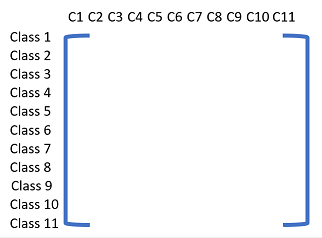

3.   Suppose the detection of class 7 from 4 is of interest: RR(4,5)

First data clases are arranged in the order of (C4,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11)

Then, as mentioned, for each selected epoch of C4, we would have two arrays of data, $F_1$ for the whole dataset, and the same-length $T_1$. The score and threshold for the assumed formation look like:

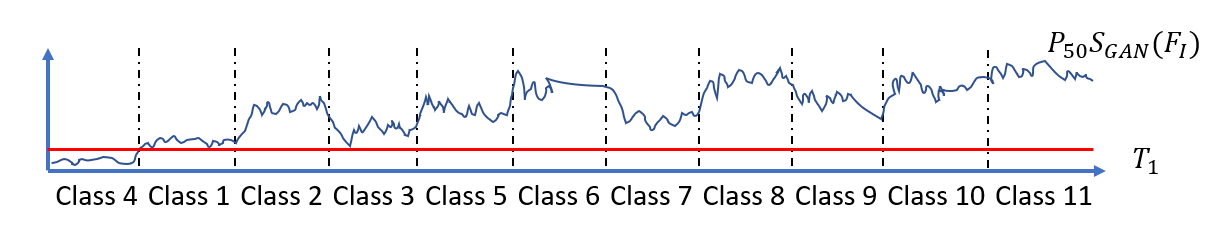

4.   For the case of the Simple threshold, the prior diagram is enough. But for the Adaptive threshold, the threshold must be updated to the end of the C4, then continues to the end of C1, then again instantiated as the end of C4, and goes to the end of C2, and so on... **The code below shows one of these instances to let the user know how the threshold is being updated.**

5. So, how does the detection work. Let's take a look at the detection of C7 from C4. First $P_{50}S_{GAN}(F_I)$ is substracted from $T_1$ or $T_{1A}$. Detection occurs if the resulting array have any "+" values.

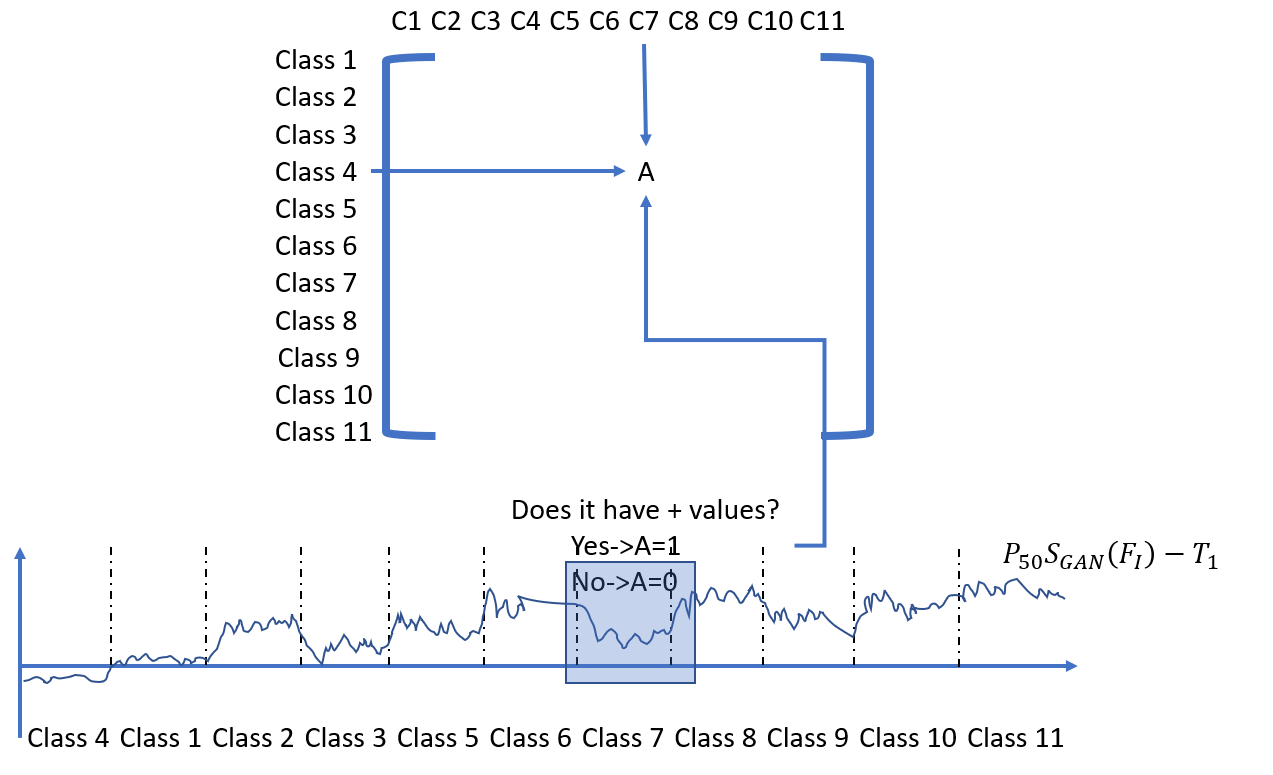

6.   The perfect detection would have 110 "1" values for each data class permutation with fixed epochs. So, to evaluate accuracy, the sum of the RR matrix is divided by 110, and the mean value across all $3^{11}$ (2048) selection of epochs is reported.

In [ ]:
## key is the same "key" as in the first notebook
#Thr is the threshold type: Simple and Adaptive
V_L=10
key='Range'
Thr='Adaptive'
#Thr='Simple'
if Thr=='Adaptive':
  THR=1
  Thr_L='$T_{1A}$'
else:
  THR=0
  Thr_L='$T_{1}$'
# C_N is the number of data intances in each class
C_N=(np.ones((11,1))*np.floor(262/V_L)*V_L).reshape((1,-1))
C_N=C_N[0]
C_Nref=np.copy(C_N)
E1=np.cumsum(C_N)
from tqdm import tqdm
TAM=[]

# number of epochs
t1=2
inner_bar = tqdm(range(2**11), desc = 'Instance of epoch selection:', leave = True, position=0)
for i1 in range(t1):
  for i2 in range(t1):
    for i3 in range(t1):
      for i4 in range(t1):
        for i5 in range(t1):
          for i6 in range(t1):
            for i7 in range(t1):
               for i8 in range(t1):
                  for i9 in range(t1):
                    for i10 in range(t1):
                     for i13 in range(t1):
                            inner_bar.update(1)
                            AMM=[i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i13]
                            TA=0
                            for ill in range(0,11):
                              AD=os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(ill+1)+'/'+key+'/')
                              filename2=os.path.join(AD+'DATA'+str(int(AMM[ill]+1))+'.pik') 
                              with open(filename2, 'rb') as f:
                                A_D=pickle.load(f)
                              exec('GAN_S1%s=A_D[0,:]' %(ill+1))
                              exec('GAN_S1%s=GAN_S1%s[0:int(Class_L[10])]' %(ill+1,ill+1))
                              exec('T80_S1%s=A_D[1,:]' %(ill+1))
                              exec('T80_S1%s=np.reshape(T80_S1%s,(len(T80_S1%s),1))' %(ill+1,ill+1,ill+1))

                            RR=np.zeros((11,11))
                            Zop=np.arange(0,11,1)
                            for i in range(0,11):
                              C_N=C_Nref
                              if i==0:
                                for ie in range(11):
                                  exec('WW=GAN_S1%s[0:int(Class_L[0])]' %(ie+1))
                                  exec('GAN_S1%s=np.delete(GAN_S1%s,np.arange(0,int(Class_L[0]),1))' %(ie+1,ie+1))
                                  exec('GAN_S1%s=np.concatenate((WW,GAN_S1%s))' %(ie+1,ie+1))
                                  exec('GAN_S%s=GAN_S1%s' %(1,i+1))
                                  exec('T80_S%s=T80_S1%s' %(1,i+1))

                              else:
                                for ie in range(11):
                                  exec('WW=GAN_S1%s[int(Class_L[i-1]):int(Class_L[i])]' %(ie+1))
                                  exec('GAN_S1%s=np.delete(GAN_S1%s,np.arange(int(Class_L[i-1]),int(Class_L[i]),1))'%(ie+1,ie+1))
                                  exec('GAN_S1%s=np.concatenate((WW,GAN_S1%s))' %(ie+1,ie+1))
                                a=C_N
                                C_N=np.concatenate((a[i:i+1], a[0:i], a[i+1::]))
                                a=Zop
                                Zop=np.concatenate((a[i:i+1], a[0:i], a[i+1::]))    
                                exec('GAN_S%s=GAN_S1%s' %(1,i+1))
                                exec('T80_S%s=T80_S1%s' %(1,i+1))
                              Class_L=np.cumsum(C_N)/DL
                              for t in range(1):
                                exec('T80_S2%s=np.concatenate((T80_S%s[0:5],[T80_S%s[k]+THR*np.mean(GAN_S%s[0:k]) for k in range(5,int(Class_L[0]))]))' %(t+1,t+1,t+1,t+1))

                              for j in range(1,11):
                                  t=0
                                  exec('GAN_S1P%s=np.concatenate((GAN_S%s[0:int(Class_L[0])],GAN_S%s[int(Class_L[j-1]):int(np.ceil(Class_L[j]))]))' %(t+1,t+1,t+1))
                                  exec('T80_S3%s=np.array([float(T80_S%s[0])+THR*np.mean(GAN_S1P%s[0:k]) for k in range(int(Class_L[0]),int(int(Class_L[j])-Class_L[j-1]+Class_L[0]))]).reshape(int(Class_L[j-1]-int(Class_L[j])),1)' %(t+1,t+1,t+1))
                                  exec('T80_S2%s=np.concatenate((T80_S2%s, T80_S3%s))' %(t+1,t+1,t+1))

                              GAN_S21=GAN_S1
                              GAN_S1=np.reshape(GAN_S1,(len(GAN_S1),1))
                              SCORE=T80_S21-GAN_S1
                              for il in range(0,11):
                                Q=SCORE[int(Class_L[il-1]):int(Class_L[il])]
                                if il==0:
                                  RR[il,0]=len(Q[Q<=0])
                                else:
                                 if len(Q[Q<=0])>0:
                                    RR[i,il]=1
                              U=np.delete(RR,0,axis=1)
                            TAA=np.append(TAA,np.sum(U))
                            TAM.append(np.sum(U))
print('\n Mean Permutation Detection is:\t',np.mean(TAM)/110,'\n','std of Permutation Detection',np.std(TAM)/110,'\n') 
print('A sample detection array\n')
plt.plot(GAN_S1)
plt.plot(T80_S21)
plt.legend(['$P_{50}S_{GAN}(F_I)$',Thr_L],fontsize=16)
plt.show() 
print('A sample RR matrix:\n',np.delete(RR,0,axis=1))

# End